Find possible instances of scriptural and apocryphal citations 

In [ ]:
import sys 
sys.path.append('../')
from lib.standardization import * 

In [2]:
outputs = []
with open('../assets/sermons_marginalia.csv', 'r') as file:          
    notes = csv.reader(file, delimiter=',')

    formatting_outliers = []
    citations, outliers = [],[]
    for idx, entry in enumerate(notes):
        # output dictionary 
        info_dict = {'idx':idx, 'tcpID':entry[0],'citations':None, 'outliers':None,'original':entry[-1]}
        # get note text 
        n = entry[-1]
        n = clean_text(n)
        # find possible citations 
        n = replaceBook(n)
        match = re.findall(r'([a-z*]+ [\d*\,\&\-\— ]+)', n)
        c,o = [],[]
        if len(match) > 0: 
            for item in match:
                item = item.strip(" ")
                item = item.split(" ")
                book = item[0]
                if len(item) == 2 and item[1] == "&":
                    continue # trivial case of "<word> &"
                if len(item) == 1: 
                    continue 
                item = " ".join(item)
                if book not in abbrev and book not in numBook.values():
                    o.append(item)
                else: 
                    decomposed = findCitations(item)
                    c.extend(decomposed[0])
                    o.extend(decomposed[1])
                    formatting_outliers.extend(decomposed[1])                     
            info_dict['citations'] = "; ".join(c) 
            info_dict['outliers'] = "; ".join(o)
            outputs.append(info_dict)
            citations.extend(c)
            outliers.extend(o)
        if (idx+1) % 100000 == 0: 
            print(f"Processed {idx+1} entries")


outfile = open("../outputs/citations.csv","w+")
writer = csv.DictWriter(outfile, fieldnames=["idx","tcpID","citations","outliers","original"])
writer.writeheader()
for dict in outputs: 
    writer.writerow(dict)
outfile.close()

Processed 100000 entries
Processed 200000 entries
Processed 300000 entries
Processed 400000 entries
Processed 500000 entries
Processed 600000 entries


In [38]:
from collections import defaultdict

catalog = {}
for dict in outputs: 
    c = dict["citations"].split(" ")
    if len(c[0]) == 0: 
        continue
    tcpID = dict["tcpID"]
    if tcpID not in catalog: 
        catalog[tcpID] = {'only_chapter':0,'verse':0,'corrupted_ch_only':0,'corrupted_v_only':0,'all_corrupt':0}
    if re.match(r'[\d\*]',c[0]): 
        book = f"{c[0]} {c[1]}"
        ref = c[2]
    else: 
        book = c[0]
        ref = c[1]
    ref = ref.split(".")
    chapter = ref[0]
    if "*" in chapter and len(ref) < 2: 
        catalog[tcpID]['corrupted_ch_only'] += 1 
    elif len(ref) == 2: 
        verse = ref[1] 
        if "*" in verse: 
            if '*' in chapter: 
                catalog[tcpID]['all_corrupt'] += 1 
            else: 
                catalog[tcpID]['corrupted_v_only'] += 1 
        else: 
            catalog[tcpID]['verse'] += 1 
    else: 
        catalog[tcpID]['only_chapter'] += 1 

In [65]:
for tcpID, dict in catalog.items():
    corrupt = dict["all_corrupt"] + dict["corrupted_v_only"] + dict["corrupted_ch_only"]
    total = dict["verse"]+corrupt + dict["only_chapter"]
    corrupt_ratio = 0 
    if total > 0: 
        corrupt_ratio = corrupt/total
    catalog[tcpID]['corrupt_ratio'] = corrupt_ratio 
    catalog[tcpID]['total'] = total
    
sorted_catalog = sorted(catalog, key= lambda x: (catalog[x]['corrupt_ratio'],
                                                 catalog[x]['total']),reverse=True)

In [73]:
not_corrupted = []
low_corruption = []
high_corruption = []
for tcpID in sorted_catalog: 
    if catalog[tcpID]['corrupt_ratio'] == 0: 
        not_corrupted.append(tcpID)
    elif catalog[tcpID]['corrupt_ratio'] < 0.1: 
        low_corruption.append(tcpID)
    elif catalog[tcpID]['corrupt_ratio'] > 0.2: 
        high_corruption.append(tcpID)
        if catalog[tcpID]['total'] > 10: 
            print(tcpID, catalog[tcpID]['total'], "total",
                catalog[tcpID]['corrupted_ch_only'],'corrupted chapters',
                catalog[tcpID]['corrupted_v_only'],'corrupted verses',
                catalog[tcpID]['all_corrupt'],'completely corrupted' )
print(len(not_corrupted), "with citations not corrupted and",len(low_corruption),"texts with small ratios of corrupted citations")
print(len(high_corruption), "texts with high corruption ratios")
print(len(sorted_catalog) - (len(not_corrupted) + len(low_corruption) + len(high_corruption)),'texts with moderate corruption ratios')

B00422 42 total 9 corrupted chapters 13 corrupted verses 1 completely corrupted
A02461 20 total 9 corrupted chapters 0 corrupted verses 0 completely corrupted
A10353 442 total 71 corrupted chapters 79 corrupted verses 44 completely corrupted
B22963 30 total 2 corrupted chapters 11 corrupted verses 0 completely corrupted
A04214 181 total 59 corrupted chapters 15 corrupted verses 1 completely corrupted
A05143 365 total 136 corrupted chapters 5 corrupted verses 1 completely corrupted
A02242 31 total 12 corrupted chapters 0 corrupted verses 0 completely corrupted
A79477 21 total 4 corrupted chapters 4 corrupted verses 0 completely corrupted
A01331 17 total 0 corrupted chapters 5 corrupted verses 1 completely corrupted
A15453 37 total 3 corrupted chapters 6 corrupted verses 4 completely corrupted
A17338 20 total 4 corrupted chapters 3 corrupted verses 0 completely corrupted
A04085 18 total 1 corrupted chapters 3 corrupted verses 2 completely corrupted
A02359 19 total 6 corrupted chapters 0 

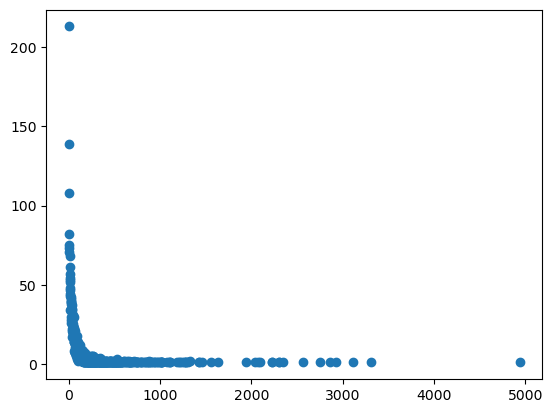

In [78]:
from matplotlib.pyplot import scatter 
from collections import Counter
counts = Counter(([catalog[tcpID]['total'] for tcpID in sorted_catalog]))
scatter(counts.keys(),counts.values())

In [ ]:
for tcpID, dict in catalog.items():
    corrupt_verses = dict["all_corrupt"] + dict["corrupted_v_only"]
    corrupt_chapters = dict["corrupted_ch_only"]
    total_verses = dict["verse"]+corrupt_verses
    total_chapters = dict["only_chapter"]+corrupt_chapters
    if total_verses > 0: 
        v_ratio = corrupt_verses/total_verses
    if total_chapters > 0: 
        c_ratio = corrupt_chapters/total_chapters
    catalog[tcpID]['corrupt_ch_ratio'] = c_ratio 
    catalog[tcpID]['corrupt_v_ratio'] = v_ratio 
sorted_catalog = sorted(catalog, key= lambda x: (catalog[x]['corrupt_ch_ratio'], 
                                                catalog[x]['corrupt_v_ratio']))
for tcpID in reversed(sorted_catalog): 
    print(catalog[tcpID])

In [4]:
for item in formatting_outliers: 
    if len(item.split(" ")) > 2: 
        print(item)

amos 8 4 5-11
nehemiah 2 4-4 4-4 9-5 19-6 14-13 14-22-29
nehemiah 1 8-6 14-13 14-22-29-31
john 19 1-6-15
acts 14 14 15-8
revelation 7 7 8-10 11
11 4, 5, 7 8, 20, 21, 33-34
acts 2 24 32 3 15, 26 4 10 5 30 13-30, 33
john 5 24 3-18
hebrews 10 32-34 11 24-26
onepeter onepeter 4 12-19 3 14-17
twothessalonians 3 7 9-8
psalms 113 5 *-7
psalms 62 11-2-79 12
unknownpeter 2 19 20-26
onecorinthians onecorinthians 5 1 9-11 6 9-18 7 1
leviticus 4 3 29 33-5 6, 7 9 11-9 22-12 6, 8-14 13-16 16
matthew 17 10 11-11 14
psalms 42 3-10-69 19 80 5 6-89 50, 51-123 3, 4
onetimothy 1 4 6-2 7
genesis 30 35-37 13 14-42 1, 2, 3-43 15-47 1, 2, 3
john 14 1 15 11-16 33
onesamuel 20 30 33-22 8
psalms 25-94-55-42 143 2, 3
psalms 62 11-12-79 12
3 24 5, 15-17
revelation 3 5 21-21 7-22 5
90 5, 7, 8,-11
ecclesiasticus 33 5 7-13
jeremiah 9 5 2-8
james 2 5 1-4
twocorinthians 2 17-,
luke 24 9 10-50 51
2 12, 14,-19
onecorinthians onecorinthians 51 9-11 6 9-18 7 1,


In [57]:
# from collections import Counter
# from difflib import SequenceMatcher
# possible_abbrev = []
# for o in outliers: 
#     possible_abbrev.append(o.split(" ")[0]) 

# possible_abbrev = Counter(possible_abbrev).items()
# possible_matches = {k:[] for k in abbrev}
# for word,freq in possible_abbrev:
#     # print(word)
#     # finding possible matches to any of the known abbreviations for each book
#     if word not in abbrev_to_book: 
#         for ab, book in abbrev_to_book.items():
#             similarity = SequenceMatcher(None, ab, word).ratio()
#             if similarity >= 0.8:
#                 possible_matches[book].append((word,freq))
#                 break

In [58]:
# clean_format = []
# for book, variants in possible_matches.items(): 
#     for v,freq in variants:
#         clean_format.append(f"{book}: {v} {freq}\n") 
#     clean_format.append("\n")
# with open(f"../assets/possible_variants_2.txt","w+") as file: 
#     file.writelines(clean_format)

In [ ]:
# with open(f"../assets/possible_variants_2 copy.txt","r") as file: 
#     lines = file.readlines() 
# for line in lines: 
#     line = line.split(" ")
#     b, ab = line[0].strip(":"), line[1]
#     abbrev[b].append(ab)
# count = 0 
# for b,ab_list in abbrev.items(): 
#     print(f"'{b}':")
#     print("[")
#     for ab in sorted(set(ab_list)): 
#         print(f"\t'{ab}',")
#     print(f"],")